In [1]:

import pandas as pd
import numpy as np

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset

from helper.model_plots import *

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA



In [144]:

days = pd.read_parquet('data/daily.parquet',engine='fastparquet')
labeled_users = pd.read_parquet('data/labeled_users.parquet',engine='fastparquet')
bets = pd.read_parquet('data/bets.parquet',engine='fastparquet')


In [145]:
labeled_users.groupby('cluster_label').size()


cluster_label
0    25726
1     1960
2     3427
3       91
4      483
5      415
dtype: int64

In [146]:
target_cluster_users = labeled_users[labeled_users['cluster_label'] == 0]['user_id'].to_list()
target_cluster_users[:5]


[44, 46, 5977, 7612, 9388]

In [147]:
target_cluster_users_days = days[days['user_id'].isin(target_cluster_users)]
target_cluster_users_days.head()


,user_id,day_of_year,odds_log_mean,odds_log_std,bet_prop_log_mean,bet_prop_log_std,n_sessions,n_active_hours,bet_top1hour%,bet_top2hours%,bet_top4hours%,bet_mean_abs_dev_uniform%,odd_top1hour%,odd_top2hours%,odd_top4hours%,odd_mean_abs_dev_uniform%,slope_bet_day,slope_odd_day,n_bet_proportion
0,44,253,0.045360,0.027368,0.000000,0.000000,1.0,2,0.500000,1.000000,1.000000,0.076389,0.505995,1.000000,1.000000,0.076389,0.000000,0.001335,1.000000
1,44,254,0.537515,0.259239,1.242422,0.736760,1.0,2,0.825483,1.000000,1.000000,0.076389,0.515239,1.000000,1.000000,0.076389,-0.029744,-0.013300,1.666667
2,44,255,0.029559,0.000000,-0.069071,0.000000,1.0,1,1.000000,1.000000,1.000000,0.079861,1.000000,1.000000,1.000000,0.079861,-0.000210,0.000090,0.312500
3,44,257,0.036531,0.027343,0.324303,0.698184,3.0,3,0.559135,0.782729,0.782729,0.072917,0.338710,0.670968,0.670968,0.072917,0.001503,0.000293,1.342282
4,44,259,0.095418,0.104053,-0.068377,0.002970,1.0,1,1.000000,1.000000,1.000000,0.079861,1.000000,1.000000,1.000000,0.079861,-0.009365,0.013068,4.866970


In [148]:
target_cluster_users_days.columns


Index(['user_id', 'day_of_year', 'odds_log_mean', 'odds_log_std',
       'bet_prop_log_mean', 'bet_prop_log_std', 'n_sessions', 'n_active_hours',
       'bet_top1hour%', 'bet_top2hours%', 'bet_top4hours%',
       'bet_mean_abs_dev_uniform%', 'odd_top1hour%', 'odd_top2hours%',
       'odd_top4hours%', 'odd_mean_abs_dev_uniform%', 'slope_bet_day',
       'slope_odd_day', 'n_bet_proportion'],
      dtype='object')

In [149]:
target_days = target_cluster_users_days.drop(columns=['user_id','day_of_year','odd_mean_abs_dev_uniform%', 'odd_top1hour%', 'odd_top2hours%', 'odd_top4hours%','bet_mean_abs_dev_uniform%'])
target_days.head()


,odds_log_mean,odds_log_std,bet_prop_log_mean,bet_prop_log_std,n_sessions,n_active_hours,bet_top1hour%,bet_top2hours%,bet_top4hours%,slope_bet_day,slope_odd_day,n_bet_proportion
0,0.045360,0.027368,0.000000,0.000000,1.0,2,0.500000,1.000000,1.000000,0.000000,0.001335,1.000000
1,0.537515,0.259239,1.242422,0.736760,1.0,2,0.825483,1.000000,1.000000,-0.029744,-0.013300,1.666667
2,0.029559,0.000000,-0.069071,0.000000,1.0,1,1.000000,1.000000,1.000000,-0.000210,0.000090,0.312500
3,0.036531,0.027343,0.324303,0.698184,3.0,3,0.559135,0.782729,0.782729,0.001503,0.000293,1.342282
4,0.095418,0.104053,-0.068377,0.002970,1.0,1,1.000000,1.000000,1.000000,-0.009365,0.013068,4.866970


In [150]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(target_days)
X_scaled[0]

# original_X = scaler.inverse_transform(X_scaled)
# original_X[0]


array([-1.35971489, -0.96009637,  0.37444265, -0.72474081, -0.41628169,
        0.38431814, -2.64275586,  0.19152218,  0.19152218,  0.00554666,
        0.02954102, -0.1260714 ])

In [151]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device


device(type='cuda')

In [152]:
class Autoencoder(nn.Module):
    def __init__(self, input_dim, intermediate_dim, encoding_dim):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, intermediate_dim),
            nn.ReLU(),
            nn.Linear(intermediate_dim, encoding_dim),
        )
        self.decoder = nn.Sequential(
            nn.Linear(encoding_dim, intermediate_dim),
            nn.ReLU(),
            nn.Linear(intermediate_dim, input_dim),
        )

    def forward(self, x):
        z = self.encoder(x)
        x_hat = self.decoder(z)
        return x_hat


In [153]:
input_dim = X_scaled.shape[1]
encoding_dim = 4
intermediate_dim = 8


model = Autoencoder(input_dim, intermediate_dim, encoding_dim).to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)


In [154]:
tensor_x = torch.tensor(X_scaled, dtype=torch.float32)
dataset = TensorDataset(tensor_x) 
loader = DataLoader(dataset, batch_size=64, shuffle=True)


In [155]:
n_epochs = 50

for epoch in range(n_epochs):
    model.train()
    epoch_loss = 0.0

    for (batch,) in loader:
        batch = batch.to(device)

        optimizer.zero_grad()
        recon = model(batch)
        loss = criterion(recon, batch)

        loss.backward()
        optimizer.step()

        epoch_loss += loss.item() * batch.size(0)

    epoch_loss /= len(dataset)
    print(f"Epoch {epoch+1}/{n_epochs} - Loss: {epoch_loss:.6f}")


Epoch 1/50 - Loss: 0.602465
Epoch 2/50 - Loss: 0.376643
Epoch 3/50 - Loss: 0.304568
Epoch 4/50 - Loss: 0.270873
Epoch 5/50 - Loss: 0.252250
Epoch 6/50 - Loss: 0.238752
Epoch 7/50 - Loss: 0.232404
Epoch 8/50 - Loss: 0.229365
Epoch 9/50 - Loss: 0.227466
Epoch 10/50 - Loss: 0.226212
Epoch 11/50 - Loss: 0.225345
Epoch 12/50 - Loss: 0.223458
Epoch 13/50 - Loss: 0.221704
Epoch 14/50 - Loss: 0.220100
Epoch 15/50 - Loss: 0.217696
Epoch 16/50 - Loss: 0.215704
Epoch 17/50 - Loss: 0.213707
Epoch 18/50 - Loss: 0.212248
Epoch 19/50 - Loss: 0.210650
Epoch 20/50 - Loss: 0.209340
Epoch 21/50 - Loss: 0.207881
Epoch 22/50 - Loss: 0.206558
Epoch 23/50 - Loss: 0.205387
Epoch 24/50 - Loss: 0.203850
Epoch 25/50 - Loss: 0.202853
Epoch 26/50 - Loss: 0.201579
Epoch 27/50 - Loss: 0.200045
Epoch 28/50 - Loss: 0.198763
Epoch 29/50 - Loss: 0.197553
Epoch 30/50 - Loss: 0.195702
Epoch 31/50 - Loss: 0.193653
Epoch 32/50 - Loss: 0.192159
Epoch 33/50 - Loss: 0.190334
Epoch 34/50 - Loss: 0.189061
Epoch 35/50 - Loss: 0.1

In [156]:
X_tensor = torch.tensor(X_scaled, dtype=torch.float32).to(device)

with torch.no_grad():
    X_recon = model(X_tensor).cpu().numpy()
    
recon_error = ((X_scaled - X_recon) ** 2).mean(axis=1)


In [157]:
recon_error.mean(), recon_error.sum()


(0.17819685136764163, 12674.429250374878)

In [158]:
np.percentile(recon_error, [50, 80, 90, 95, 99])


array([0.04180931, 0.19329047, 0.39024604, 0.68822632, 1.79906689])

In [159]:
recon_target = target_cluster_users_days.copy()
recon_target["recon_error"] = recon_error
recon_target.head()


,user_id,day_of_year,odds_log_mean,odds_log_std,bet_prop_log_mean,bet_prop_log_std,n_sessions,n_active_hours,bet_top1hour%,bet_top2hours%,bet_top4hours%,bet_mean_abs_dev_uniform%,odd_top1hour%,odd_top2hours%,odd_top4hours%,odd_mean_abs_dev_uniform%,slope_bet_day,slope_odd_day,n_bet_proportion,recon_error
0,44,253,0.045360,0.027368,0.000000,0.000000,1.0,2,0.500000,1.000000,1.000000,0.076389,0.505995,1.000000,1.000000,0.076389,0.000000,0.001335,1.000000,0.059617
1,44,254,0.537515,0.259239,1.242422,0.736760,1.0,2,0.825483,1.000000,1.000000,0.076389,0.515239,1.000000,1.000000,0.076389,-0.029744,-0.013300,1.666667,0.063445
2,44,255,0.029559,0.000000,-0.069071,0.000000,1.0,1,1.000000,1.000000,1.000000,0.079861,1.000000,1.000000,1.000000,0.079861,-0.000210,0.000090,0.312500,0.001559
3,44,257,0.036531,0.027343,0.324303,0.698184,3.0,3,0.559135,0.782729,0.782729,0.072917,0.338710,0.670968,0.670968,0.072917,0.001503,0.000293,1.342282,0.516081
4,44,259,0.095418,0.104053,-0.068377,0.002970,1.0,1,1.000000,1.000000,1.000000,0.079861,1.000000,1.000000,1.000000,0.079861,-0.009365,0.013068,4.866970,0.130782


In [160]:
recon_target.sort_values(by='recon_error', ascending=False).head(100)


,user_id,day_of_year,odds_log_mean,odds_log_std,bet_prop_log_mean,bet_prop_log_std,n_sessions,n_active_hours,bet_top1hour%,bet_top2hours%,bet_top4hours%,bet_mean_abs_dev_uniform%,odd_top1hour%,odd_top2hours%,odd_top4hours%,odd_mean_abs_dev_uniform%,slope_bet_day,slope_odd_day,n_bet_proportion,recon_error
76596,1343144,262,0.488175,0.243778,-20.149755,2.292228,2.0,6,0.969481,0.999335,0.999335,0.077318,0.193513,0.384424,0.384424,0.062500,-94.806808,2.314013,1.731366,106.050372
58730,1249661,264,0.483160,0.251357,-14.406376,2.364061,1.0,6,0.999231,0.999618,0.999618,0.079797,0.170422,0.337902,0.337902,0.062500,-77.588173,2.660894,54.897495,55.536461
53100,1213084,257,1.003245,0.954462,0.131834,0.428262,1.0,10,0.290027,0.388054,0.388054,0.048611,0.183586,0.321322,0.321322,0.048611,0.153848,6.679101,1.000000,48.056545
76589,1343144,255,0.259875,0.109121,-6.937788,5.713368,3.0,24,0.793804,0.833604,0.833604,0.062678,0.044668,0.089159,0.089159,0.003035,25.525318,1.587444,12.133137,43.683674
58990,1251347,256,0.282147,0.100298,-9.453470,3.334619,1.0,9,0.551242,0.940271,0.940271,0.071411,0.112225,0.224187,0.224187,0.052083,-62.824471,2.109026,11.843221,39.112253
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
73923,1330520,261,1.228025,0.760533,-0.535016,1.243784,3.0,12,0.189092,0.329169,0.329169,0.049911,0.152374,0.269872,0.269872,0.041707,1.051157,-2.792417,0.581758,7.480787
126371,1488502,270,1.099918,0.816280,-0.623039,2.521021,2.0,3,0.941136,0.989212,0.989212,0.075490,0.509265,0.897848,0.897848,0.072917,0.070648,-2.569165,1.000000,7.250072
126178,1487924,269,0.478512,0.246349,-12.336845,5.309333,2.0,4,0.657865,0.996043,0.996043,0.076059,0.270230,0.539417,0.539417,0.069444,-28.189550,1.065807,1.000000,7.211939
45429,1155343,254,0.919417,0.782375,-0.220084,1.206146,3.0,11,0.158155,0.313236,0.313236,0.047110,0.112775,0.222159,0.222159,0.045139,-0.250747,-2.623843,1.000000,7.106427


In [161]:
user_id = 1343144


In [162]:
recon_target[recon_target['user_id'] == user_id]


,user_id,day_of_year,odds_log_mean,odds_log_std,bet_prop_log_mean,bet_prop_log_std,n_sessions,n_active_hours,bet_top1hour%,bet_top2hours%,bet_top4hours%,bet_mean_abs_dev_uniform%,odd_top1hour%,odd_top2hours%,odd_top4hours%,odd_mean_abs_dev_uniform%,slope_bet_day,slope_odd_day,n_bet_proportion,recon_error
76586,1343144,252,0.082160,0.029405,0.004474,0.324964,1.0,1,1.000000,1.000000,1.000000,0.079861,1.000000,1.000000,1.000000,0.079861,0.000224,0.004108,1.000000,0.001111
76587,1343144,253,0.447913,0.264201,-6.956625,3.732180,5.0,17,0.478979,0.724440,0.724440,0.060685,0.072024,0.143235,0.143235,0.024306,-24.999662,1.818568,189.600006,5.794526
76588,1343144,254,0.415604,0.268033,-8.350073,5.292238,5.0,20,0.239394,0.407931,0.407931,0.043566,0.063171,0.126278,0.126278,0.014472,-6.819167,0.431337,9.425982,4.143616
76589,1343144,255,0.259875,0.109121,-6.937788,5.713368,3.0,24,0.793804,0.833604,0.833604,0.062678,0.044668,0.089159,0.089159,0.003035,25.525318,1.587444,12.133137,43.683674
76590,1343144,256,0.275335,0.150446,-1.341311,3.055242,5.0,15,0.284287,0.431053,0.431053,0.052673,0.091766,0.172807,0.172807,0.031250,-2.774937,-0.211944,1.507734,1.179971
76591,1343144,257,0.298647,0.182779,-8.320445,4.231045,4.0,12,0.509672,0.712415,0.712415,0.063944,0.122120,0.230197,0.230197,0.041667,24.793695,-0.894826,1.220756,8.030678
76592,1343144,258,0.473147,0.253752,-4.541702,1.439312,3.0,4,0.995557,0.999247,0.999247,0.079491,0.304268,0.603831,0.603831,0.069444,-2.386827,0.245906,0.190235,0.152541
76593,1343144,259,0.247620,0.245071,-2.355672,3.405331,5.0,7,0.404694,0.757049,0.757049,0.070809,0.198764,0.387514,0.387514,0.059028,-1.700929,0.127813,0.259402,0.194407
76594,1343144,260,0.423216,0.267672,-17.741037,6.955709,4.0,5,0.625751,0.834073,0.834073,0.072735,0.261679,0.510745,0.510745,0.065972,-20.709650,0.489857,0.415979,5.261076
76595,1343144,261,0.387518,0.278704,-16.763519,11.229869,3.0,5,0.502742,0.983980,0.983980,0.075054,0.278323,0.459589,0.459589,0.065972,-16.318850,0.345571,0.390690,4.236999


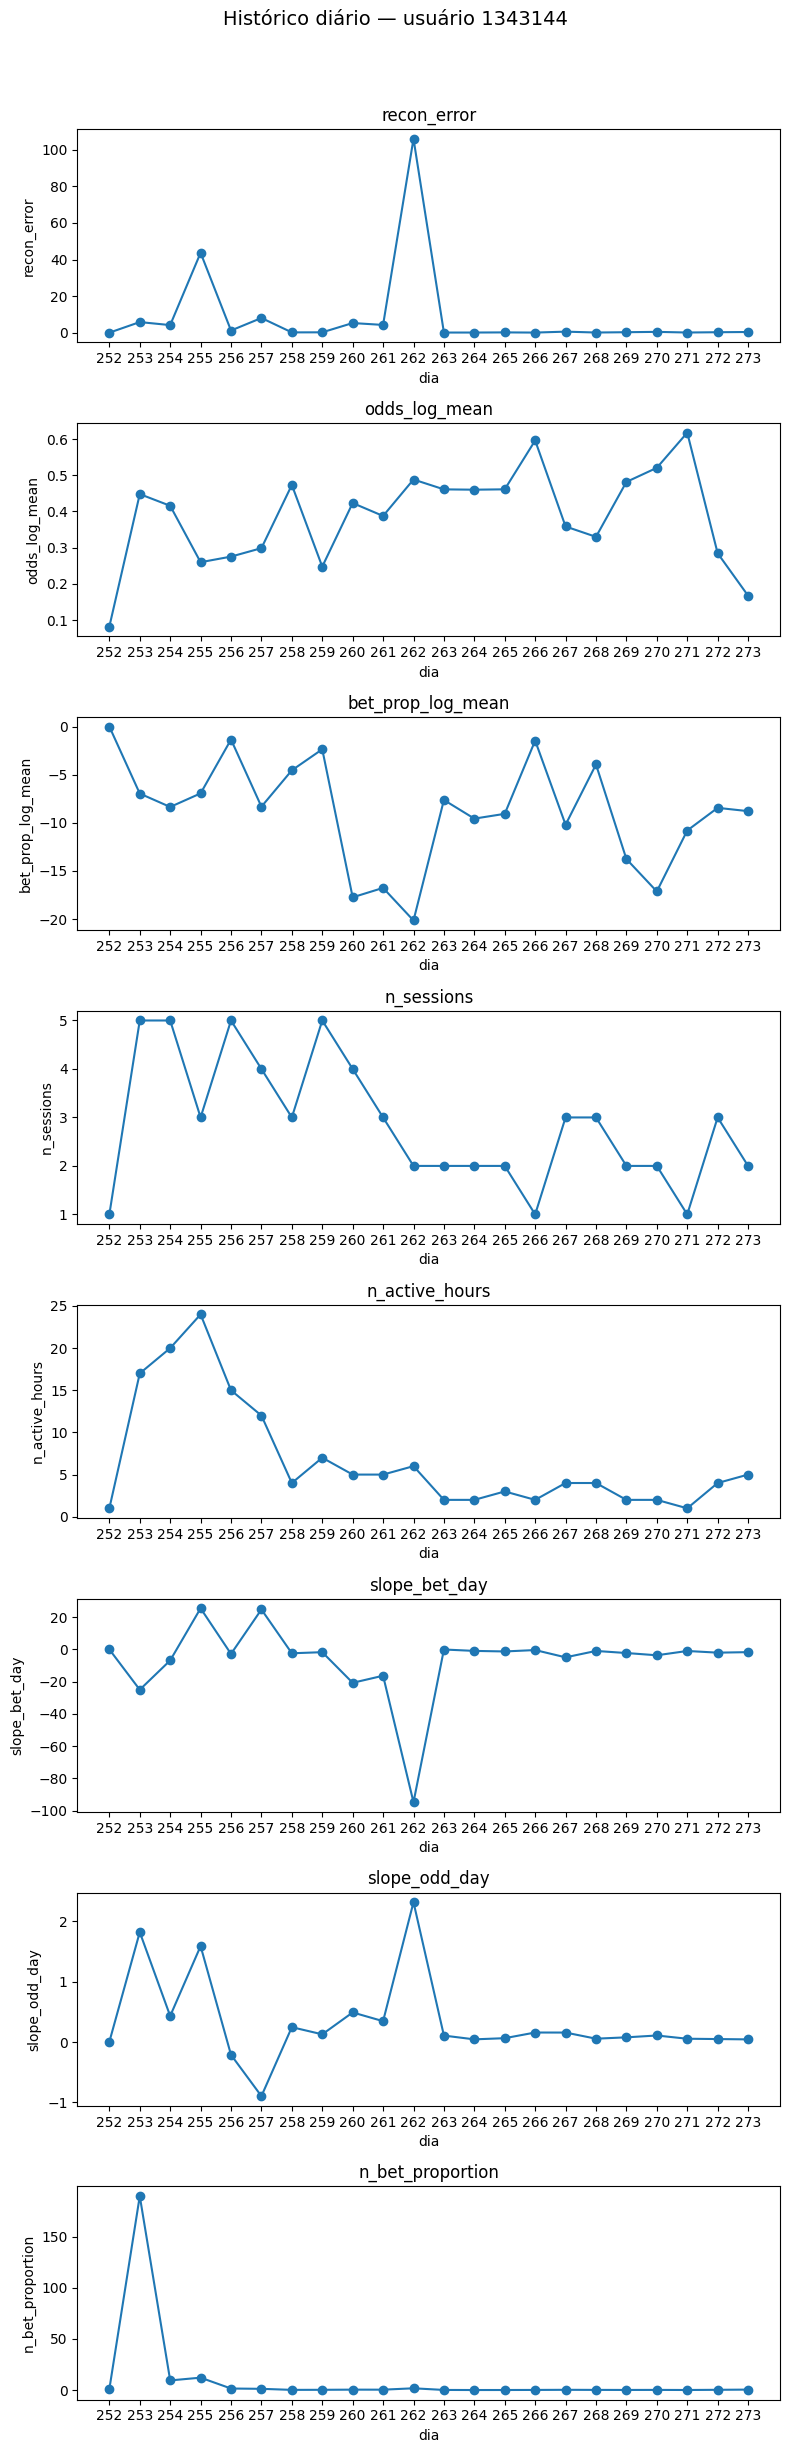

In [163]:
daily_feats = [
    'recon_error',
    'odds_log_mean', 
    # 'odds_log_std', 
    'bet_prop_log_mean',
    # 'bet_prop_log_std', 
    'n_sessions', 'n_active_hours', 
    # 'bet_top1hour%', 'bet_top2hours%', 'odd_mean_abs_dev_uniform%', 
    'slope_bet_day', 'slope_odd_day', 'n_bet_proportion',
]

plot_user_daily(recon_target, user_id=user_id, features=daily_feats)


In [166]:
day = 255


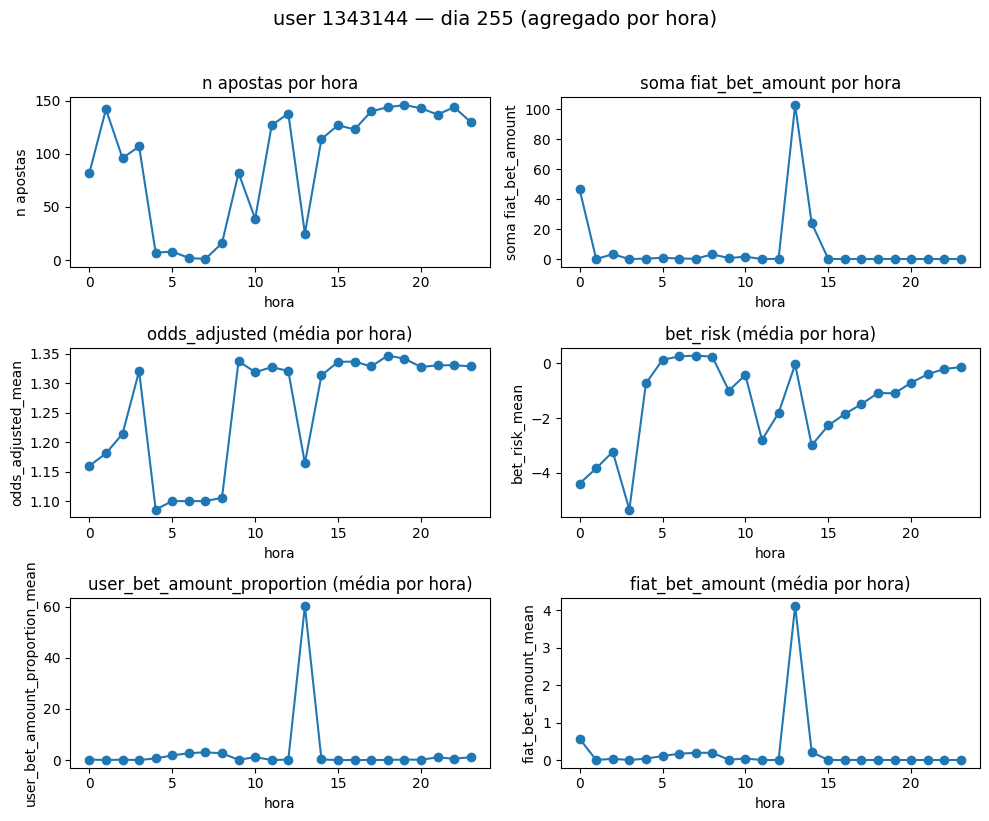

In [167]:
plot_user_day_hourly(
    df=bets,          
    user_id=user_id,
    day_of_year=day  
)


In [168]:
hour = 13


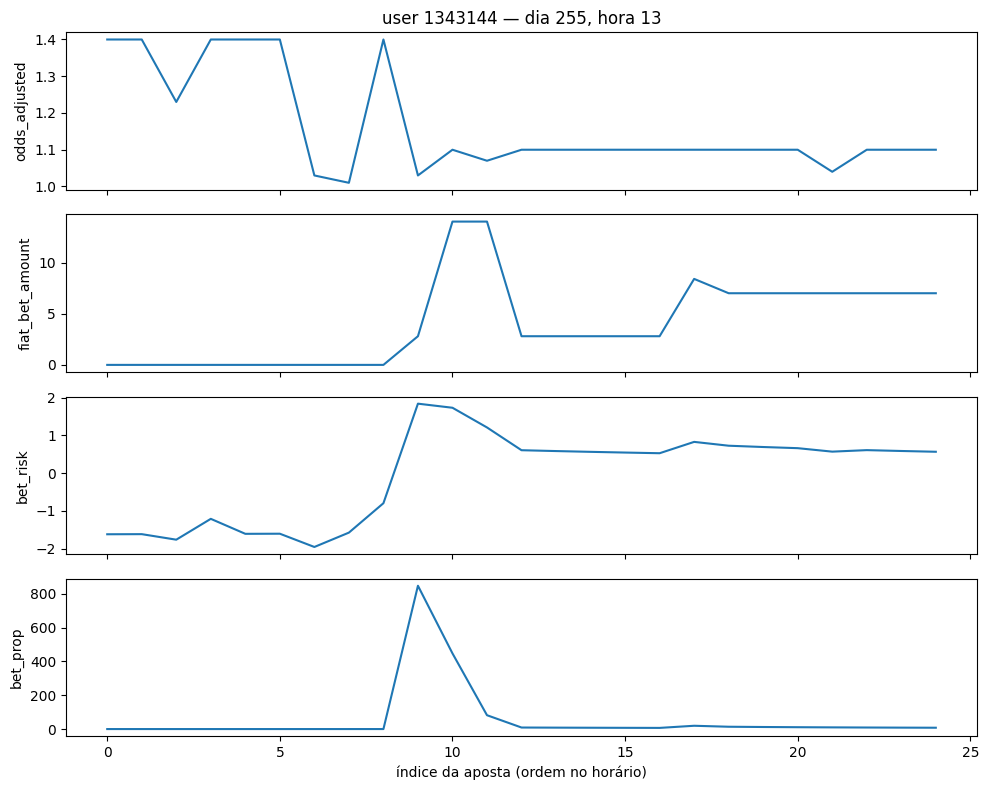

In [169]:
plot_user_hour_bets(
    df=bets,          
    user_id=user_id,
    day_of_year=day,   
    hour=hour  
)


In [170]:
all_days = days.drop(columns=['user_id','day_of_year','odd_mean_abs_dev_uniform%', 'odd_top1hour%', 'odd_top2hours%', 'odd_top4hours%','bet_mean_abs_dev_uniform%'])
all_days


,odds_log_mean,odds_log_std,bet_prop_log_mean,bet_prop_log_std,n_sessions,n_active_hours,bet_top1hour%,bet_top2hours%,bet_top4hours%,slope_bet_day,slope_odd_day,n_bet_proportion
0,0.045360,0.027368,0.000000,0.000000,1.0,2,0.500000,1.000000,1.000000,0.000000,0.001335,1.000000
1,0.537515,0.259239,1.242422,0.736760,1.0,2,0.825483,1.000000,1.000000,-0.029744,-0.013300,1.666667
2,0.029559,0.000000,-0.069071,0.000000,1.0,1,1.000000,1.000000,1.000000,-0.000210,0.000090,0.312500
3,0.036531,0.027343,0.324303,0.698184,3.0,3,0.559135,0.782729,0.782729,0.001503,0.000293,1.342282
4,0.095418,0.104053,-0.068377,0.002970,1.0,1,1.000000,1.000000,1.000000,-0.009365,0.013068,4.866970
...,...,...,...,...,...,...,...,...,...,...,...,...
130639,0.469348,0.309348,1.480713,2.308513,1.0,1,1.000000,1.000000,1.000000,-0.042490,-0.013468,1.000000
130640,0.192760,0.105671,2.745244,2.152429,1.0,1,1.000000,1.000000,1.000000,-0.064454,-0.004526,1.000000
130641,0.386987,0.334752,-8.095021,10.176622,1.0,1,1.000000,1.000000,1.000000,0.095029,-0.004543,1.000000
130642,0.165514,0.000000,0.000000,0.000000,1.0,1,1.000000,1.000000,1.000000,0.000000,-0.000648,1.000000


In [171]:
all_scaled = scaler.transform(all_days)
all_scaled[0]


array([-1.35971489, -0.96009637,  0.37444265, -0.72474081, -0.41628169,
        0.38431814, -2.64275586,  0.19152218,  0.19152218,  0.00554666,
        0.02954102, -0.1260714 ])

In [172]:
all_tensor = torch.tensor(all_scaled, dtype=torch.float32).to(device)
all_tensor[0]


tensor([-1.3597, -0.9601,  0.3744, -0.7247, -0.4163,  0.3843, -2.6428,  0.1915,
         0.1915,  0.0055,  0.0295, -0.1261], device='cuda:0')

In [173]:
with torch.no_grad():
    all_recon = model(all_tensor).cpu().numpy()


In [174]:
all_recon_error = ((all_scaled - all_recon) ** 2).mean(axis=1)


In [175]:

recon_df = days.copy()
recon_df["recon_error"] = all_recon_error


In [176]:
recon_df = recon_df.merge(labeled_users[['user_id','cluster_label']], how='left', on='user_id')


In [177]:
recon_df.groupby('cluster_label')['recon_error'].describe()


,count,mean,std,min,25%,50%,75%,max
cluster_label,,,,,,,,
0,71126.0,0.178197,0.844277,0.000317,0.008231,0.041809,0.145127,106.050372
1,20391.0,1.939863,6.024116,0.000401,0.121479,0.395297,1.222057,259.075876
2,30340.0,0.538812,2.007138,0.000456,0.047425,0.170340,0.449794,156.744507
3,389.0,6.155011,32.408842,0.000666,0.011783,0.280203,2.668173,513.196190
4,6413.0,8.271799,13.098598,0.000911,0.747490,5.295205,12.482652,277.908914
5,1985.0,1.285502,6.515167,0.000472,0.014527,0.150235,0.709186,148.437951


In [178]:
recon_df[recon_df['cluster_label'] == 3].sort_values(by='recon_error', ascending=True).head()


,user_id,day_of_year,odds_log_mean,odds_log_std,bet_prop_log_mean,bet_prop_log_std,n_sessions,n_active_hours,bet_top1hour%,bet_top2hours%,...,bet_mean_abs_dev_uniform%,odd_top1hour%,odd_top2hours%,odd_top4hours%,odd_mean_abs_dev_uniform%,slope_bet_day,slope_odd_day,n_bet_proportion,recon_error,cluster_label
36499,1015247,259,0.441473,0.383577,1.372735,1.232118,1.0,1,1.0,1.0,...,0.079861,1.0,1.0,1.0,0.079861,0.005372,0.001728,1.000000,0.000666,3
27819,905633,253,0.237900,0.066863,0.142589,0.201651,1.0,1,1.0,1.0,...,0.079861,1.0,1.0,1.0,0.079861,-0.001612,-0.002689,1.000000,0.000983,3
10250,352410,268,0.029559,0.000000,0.019812,0.000000,1.0,1,1.0,1.0,...,0.079861,1.0,1.0,1.0,0.079861,0.000164,0.000244,0.787402,0.001041,3
10249,352410,265,0.262364,0.000000,-0.156853,0.000000,1.0,1,1.0,1.0,...,0.079861,1.0,1.0,1.0,0.079861,0.000750,-0.001255,0.769231,0.001075,3
108576,1444493,257,0.500137,0.262785,0.241936,0.480102,1.0,1,1.0,1.0,...,0.079861,1.0,1.0,1.0,0.079861,-0.002840,-0.005871,1.000000,0.001119,3


In [142]:
recon_df[recon_df['cluster_label'] == 3].sort_values(by='recon_error', ascending=False).head()


,user_id,day_of_year,odds_log_mean,odds_log_std,bet_prop_log_mean,bet_prop_log_std,n_sessions,n_active_hours,bet_top1hour%,bet_top2hours%,...,bet_mean_abs_dev_uniform%,odd_top1hour%,odd_top2hours%,odd_top4hours%,odd_mean_abs_dev_uniform%,slope_bet_day,slope_odd_day,n_bet_proportion,recon_error,cluster_label
49919,1189711,255,0.934860,0.851592,-0.234100,1.021605,1.0,16,0.978414,0.982201,...,0.078062,0.078036,0.149995,0.149995,0.027778,-0.410073,-3.226305,2173.000000,2102.883965,3
67022,1296744,270,0.495845,0.245584,-1.550678,1.950643,1.0,21,0.109362,0.202227,...,0.028887,0.050118,0.099765,0.099765,0.010965,6.758613,2.554758,1435.759644,583.883332,3
30072,935139,267,0.497903,0.241827,-0.458174,1.233282,1.0,8,0.987108,0.989768,...,0.078787,0.130291,0.258489,0.258489,0.055556,-2.054982,1.200807,1020.000000,425.331808,3
107153,1441847,261,0.574519,0.199533,-5.009151,2.727260,2.0,5,0.999360,0.999940,...,0.079808,0.203020,0.405699,0.405699,0.065972,-9.684000,1.342370,945.000000,340.521324,3
32449,967686,273,0.491082,0.244183,-9.100027,6.556550,1.0,24,0.446281,0.767819,...,0.059611,0.043204,0.085923,0.085923,0.000509,111.463478,0.245441,14.498564,194.856159,3
